#Conjunto de datos IMDB(Reseñas en español)

#Contexto

Este dataset se basa en el IMDB Movie Reviews Dataset, que contiene 50,000 reseñas de películas(reducidas a 7806) con etiquetas de sentimiento positivo o negativo. Se ha añadido una traducción al español utilizando la biblioteca googletrans, que emplea la API de Google Translate. Dado que las traducciones pueden no ser perfectas, se plantea como un proyecto en evolución.

#Objetivo

Desarrollar un modelo de análisis de sentimiento en español aplicando técnicas de procesamiento de lenguaje natural (NLP), como tokenización, eliminación de stopwords y lematización, para mejorar la clasificación de opiniones positivas y negativas.

#Hipótesis

Si se aplican técnicas avanzadas de NLP y algoritmos de clasificación adecuados, es posible modelar de manera efectiva el análisis de sentimiento en textos en español, logrando una diferenciación precisa entre opiniones positivas y negativas.

#Descripción del dataset


**Variables**:

-número de línea     
-review_en: El texto en inglés de la reseña.      
-review_es: El texto en español de la reseña.      
-sentiment: El sentimiento de la reseña en inglés.        
-sentimiento: El sentimiento de la reseña en español.        

#Importación de librerías y lectura de datos

Se importan las librerías que iremos utilizando durante el proyecto, se leen y guardan los datos.

In [1]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
# Cargar modelo de spaCy en español
!python -m spacy download es_core_news_lg

nlp = spacy.load('es_core_news_lg')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Cargar dataset
df = pd.read_csv('/content/drive/MyDrive/Bases de datos/IMDB Dataset SPANISH.csv', delimiter= ';', encoding='latin-1')
df = df.rename(columns={'text': 'texto', 'label': 'sentimiento'})

In [4]:
df.sentimiento.unique()

array(['positivo', 'negativo'], dtype=object)

**Se imprimen las primeras observaciones del dataset**

In [5]:
df.head(10)

,Column1,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo
5,5,"Probably my all-time favorite movie, a story o...",Probablemente mi película favorita de todos lo...,positive,positivo
6,6,I sure would like to see a resurrection of a u...,Seguro que me gustaría ver una resurrección de...,positive,positivo
7,7,"This show was an amazing, fresh & innovative i...","Este espectáculo fue una idea increíble, fresc...",negative,negativo
8,8,Encouraged by the positive comments about this...,Alentados por los comentarios positivos sobre ...,negative,negativo
9,9,If you like original gut wrenching laughter yo...,"Si te gusta la risa original desgarradora, te ...",positive,positivo


In [6]:
# Contar la cantidad de reseñas positivas y negativas que hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?

In [7]:
# Contar la cantidad de reseñas positivas y negativas
conteo_sentimientos = df['sentimiento'].value_counts()

In [8]:
# Mostrar los resultados
print('Distribución de sentimientos en el dataset:')
print(conteo_sentimientos)

Distribución de sentimientos en el dataset:
sentimiento
negativo    3904
positivo    3901
Name: count, dtype: int64


In [9]:
# Verificar si el dataset está balanceado
porcentaje = conteo_sentimientos / conteo_sentimientos.sum() * 100
print('\nPorcentaje de cada clase:')
print(porcentaje)

# Determinar si está balanceado
umbral = 10  # Diferencia máxima permitida en porcentaje
desequilibrio = abs(porcentaje.iloc[0] - porcentaje.iloc[1])


Porcentaje de cada clase:
sentimiento
negativo    50.019218
positivo    49.980782
Name: count, dtype: float64


El dataset se encuentra balanceado, la diferencia de clases es mínima(0.04%)

In [10]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?

In [11]:
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}, Número de columnas: {num_columnas}')

Número de filas: 7805, Número de columnas: 5


El dataset contiene 7805 observaciones y 5 variables.

**Diferencias claves:**

**-**En NLP, trabajamos con texto libre que debe ser convertido en datos estructurados (ejemplo: embeddings, bag-of-words, TF-IDF).  
**-**En ML clásico, las variables suelen ser numéricas o categóricas desde el inicio.

**Preprocesamiento Diferente**   

En Machine Learning estructurado, usamos técnicas como normalización, eliminación de outliers y balanceo de clases.
En NLP, debemos convertir el texto en números, aplicando:
Tokenización
Lematización
Remoción de stopwords
Vectorización (TF-IDF, Word2Vec, BERT, etc.)

**Diferencias en Modelado**

En ML estructurado, usamos modelos como Random Forest, XGBoost o Regresión Logística sobre datos numéricos.
En NLP, usamos Redes Neuronales, Transformers o Naïve Bayes, que trabajan con representaciones vectoriales del texto.

In [12]:
# Corta a un nùmero reducido de reseñas para facilitar el procesamiento
# Las clases quedaron balanceadas?

In [13]:
# Definir el número de reseñas deseadas (por ejemplo, 1000)
n_reseñas = 3500

In [14]:
# Seleccionar un subconjunto aleatorio manteniendo el balance de clases
df_reducido = df.groupby('sentimiento', group_keys=False).apply(lambda x: x.sample(n=n_reseñas // 2, random_state=42))

<ipython-input-14-0d2a09027782>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reducido = df.groupby('sentimiento', group_keys=False).apply(lambda x: x.sample(n=n_reseñas // 2, random_state=42))


In [15]:
# Mostrar la distribución después de la reducción
print('Nueva distribución de clases después del recorte:')
print(df_reducido['sentimiento'].value_counts())

Nueva distribución de clases después del recorte:
sentimiento
negativo    1750
positivo    1750
Name: count, dtype: int64


In [16]:
# Calcular el porcentaje de cada clase
porcentaje = conteo_sentimientos / conteo_sentimientos.sum() * 100

# Mostrar los resultados
print('\nDistribución final de sentimientos:')
print(conteo_sentimientos)
print('\nPorcentaje de cada clase:')
print(porcentaje)


Distribución final de sentimientos:
sentimiento
negativo    3904
positivo    3901
Name: count, dtype: int64

Porcentaje de cada clase:
sentimiento
negativo    50.019218
positivo    49.980782
Name: count, dtype: float64


El dataset está bien balanceado, con una distribución casi idéntica de reseñas positivas y negativas. La mínima diferencia (menos del 0.04%) asegura que el análisis de procesamiento NLP no esté sesgado hacia una categoría, permitiendo obtener resultados más representativos en tareas como clasificación de sentimiento o modelado de temas.

In [17]:
# Ajustar etiquetas de sentimiento (0 = negativo, 1 = positivo)

In [18]:
# Mapear etiquetas de sentimiento a valores numéricos
df['sentimiento'] = df['sentimiento'].map({'negativo': 0, 'positivo': 1})

In [19]:
# Verificar los cambios
print(df['sentimiento'].value_counts())

sentimiento
0    3904
1    3901
Name: count, dtype: int64


In [20]:
def preprocesar_texto(texto):
    '''Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales.'''
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('spanish')]
    return ' '.join(tokens)

In [21]:
# Aplicar preprocesamiento

**Vamos a aplicarle preprocesamiento a las reseñas en español. Se realizan los siguientes pasos:**

-Conversión a minúsculas    
-Eliminación de signos de puntuación  
-Remoción de stopwords (palabras vacías como "el", "de", "la")     
-Tokenización (dividir el texto en palabras)      
-Stemming o lematización (reducir palabras a su raíz)   
-Eliminación de columnas en ingles       

In [22]:
!pip install nltk

In [23]:
import re
from nltk.stem import SnowballStemmer

In [24]:
# Inicializar el stemmer correctamente
stemmer = SnowballStemmer('spanish')

In [25]:
# Cargar stopwords en español
stop_words = set(stopwords.words('spanish'))

# Cargar modelo de spaCy para lematización en español
nlp = spacy.load('es_core_news_lg')

def preprocess_text(text):
    nltk.download('punkt_tab')
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\W', ' ', text)  # Eliminar signos de puntuación
    text = re.sub(r'\d+', '', text)  # Eliminar números
    tokens = word_tokenize(text)  # Tokenización
    tokens = [word for word in tokens if word not in stop_words]  # Remover stopwords

    # Lematización con spaCy
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

# Aplicar preprocesamiento
df['review_es_clean'] = df['review_es'].astype(str).apply(preprocess_text)

# Verificar resultado
print(df[['review_es', 'review_es_clean']].head())

Se truncaron las últimas líneas 5000 del resultado de transmisión.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is a

                                           review_es  \
0  Uno de los otros críticos ha mencionado que de...   
1  Una pequeña pequeña producción.La técnica de f...   
2  Pensé que esta era una manera maravillosa de p...   
3  Básicamente, hay una familia donde un niño peq...   
4  El "amor en el tiempo" de Petter Mattei es una...   

                                     review_es_clean  
0  crítico mencionado después ver solo oz episodi...  
1  pequeño pequeño producción técnico filmación i...  
2  pensar manera maravilloso pasar tiempo fin sem...  
3  básicamente familio niño pequeño jake pensar z...  
4  amor tiempo petter mattei película visualmente...  


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [26]:
from itertools import groupby

def remove_repeated_words(text):
    words = text.split()
    return ' '.join(key for key, _ in groupby(words))

df['review_es_clean'] = df['review_es_clean'].apply(remove_repeated_words)

In [27]:
# Eliminar palabras de 1 o 2 letras
def remove_short_words(text):
    tokens = text.split()
    tokens = [word for word in tokens if len(word) > 2]
    return ' '.join(tokens)

In [28]:
print(df[['review_es', 'review_es_clean']].sample(10))  # Muestra 10 reseñas aleatorias

                                              review_es  \
3387  Este espectáculo es posiblemente la pila de va...   
6038  Vi a esta película por primera vez a principio...   
7544  Admito que me gustó el primero, y realmente es...   
723   Para el primer panorama de Greta Garbo, MGM sa...   
1511  ¿Qué pasa si se enviaría un pelotón de G.I del...   
2104  Compré esta película en una venta de arranque ...   
3426  Hola Mary Lou: Prom Night II comienza en el Pr...   
4526  La idea de que cualquiera podría haber inventa...   
2271  Phillips ocupados pone en un infierno de una a...   
2163  Soy de Bélgica y, por lo tanto, mi escritura e...   

                                        review_es_clean  
3387  espectáculo posiblemente pila vapor grande feo...  
6038  ver película primero vez principio soler tener...  
7544  admitir gustar primero realmente esperar secue...  
723   primero panorama greta garbo mgm sabiamente el...  
1511  pasar si enviar pelotón g i ejército japonés t...  
21

In [29]:
# Eliminar la columna en inglés
df = df.drop(columns=['review_en'], errors='ignore')

In [30]:
# Verificar que la columna se eliminó correctamente
print(df.head())

   Column1                                          review_es sentiment  \
0        0  Uno de los otros críticos ha mencionado que de...  positive   
1        1  Una pequeña pequeña producción.La técnica de f...  positive   
2        2  Pensé que esta era una manera maravillosa de p...  positive   
3        3  Básicamente, hay una familia donde un niño peq...  negative   
4        4  El "amor en el tiempo" de Petter Mattei es una...  positive   

   sentimiento                                    review_es_clean  
0            1  crítico mencionado después ver solo oz episodi...  
1            1  pequeño producción técnico filmación incuestio...  
2            1  pensar manera maravilloso pasar tiempo fin sem...  
3            0  básicamente familio niño pequeño jake pensar z...  
4            1  amor tiempo petter mattei película visualmente...  


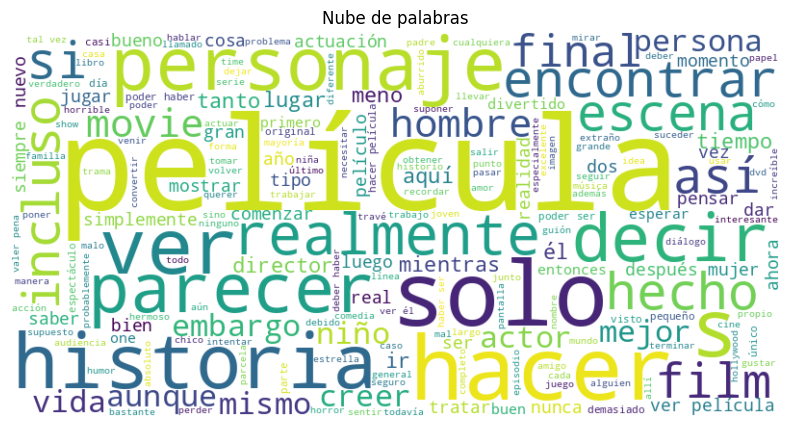

In [31]:
# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = ' '.join(df['review_es_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras')
plt.show()

In [32]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))  # Definir el rango de n-grams
    X = vectorizer.fit_transform(corpus)  # Vectorizar el texto
    ngram_counts = X.sum(axis=0).A1  # Obtener la suma de ocurrencias por n-gram
    ngram_features = vectorizer.get_feature_names_out()  # Obtener los n-grams
    ngram_freq = list(zip(ngram_features, ngram_counts))  # Emparejar n-grams con sus frecuencias
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]  # Ordenar por frecuencia

    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])


In [33]:
# Aplicar la función a la columna 'review_es_clean'
corpus = df['review_es_clean'].dropna().tolist()  # Convertir a lista y eliminar valores nulos

In [ ]:
# Lista de stopwords en español + eliminar palabras en inglés
stop_words = set(stopwords.words('spanish'))
extra_stopwords = {'the', 'and', 'of', 'to', 'in', 'it', 'is', 'one', 'film', 'rest', 'best', 'most', 'end', 'this', 'boy', 'der', 'student', 'von', 'prag'}

# Inicializar el lematizador
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    nltk.download('punkt_tab')
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\W', ' ', text)  # Eliminar signos de puntuación
    tokens = word_tokenize(text)  # Tokenización
    tokens = [word for word in tokens if word not in stop_words and word not in extra_stopwords]  # Remover stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lematización
    return " ".join(tokens)

# Aplicar nuevamente el preprocesamiento
df['review_es_clean'] = df['review_es'].astype(str).apply(preprocess_text)

In [35]:
unigrams_df = get_top_ngrams(df['review_es_clean'], n=1, top_k=10)
print('Top 10 Unigramas:')
print(unigrams_df)

Top 10 Unigramas:
      N-gram  Frecuencia
0   película       22397
1         si        5152
2  películas        4245
3       solo        4208
4   historia        3843
5        ser        3832
6        tan        3681
7        ver        3458
8  realmente        3342
9       that        2977


In [36]:
bigram_df = get_top_ngrams(df['review_es_clean'], n=2, top_k=10)
print('Top 10 Bigramas:')
print(bigram_df)

Top 10 Bigramas:
               N-gram  Frecuencia
0             tal vez         762
1        ver película         646
2          haber sido         577
3        podría haber         519
4           vale pena         464
5           puede ser         408
6        película tan         358
7       toda película         356
8  efectos especiales         331
9      buena película         328


In [37]:
trigram_df = get_top_ngrams(df['review_es_clean'], n=3, top_k=10)
print('Top 10 Trigramas:')
print(trigram_df)

Top 10 Trigramas:
                   N-gram  Frecuencia
0       podría haber sido         266
1      debería haber sido          93
2  segunda guerra mundial          89
3           vale pena ver          77
4     peor película visto          71
5           si alguna vez          63
6       película tan mala          59
7      podría haber hecho          59
8         debe haber sido          53
9      vale pena observar          53


In [38]:
cuatrigram_df = get_top_ngrams(df['review_es_clean'], n=4, top_k=10)
print('Top 10 Cuatrigramas:')
print(cuatrigram_df)

Top 10 Cuatrigramas:
                       N-gram  Frecuencia
0     podría haber sido mejor          39
1  película podría haber sido          34
2    peor película visto vida          13
3     podría haber sido buena          12
4     si quieres ver película          12
5  podría haber sido película          11
6   haber sido buena película          10
7    hacia arriba hacia abajo          10
8      película vale pena ver          10
9      vale pena ver película          10


**Corrección en preprocesamiento**

In [39]:
def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, hue='N-gram', palette='viridis', legend=False)
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('N-gram')
    plt.show()

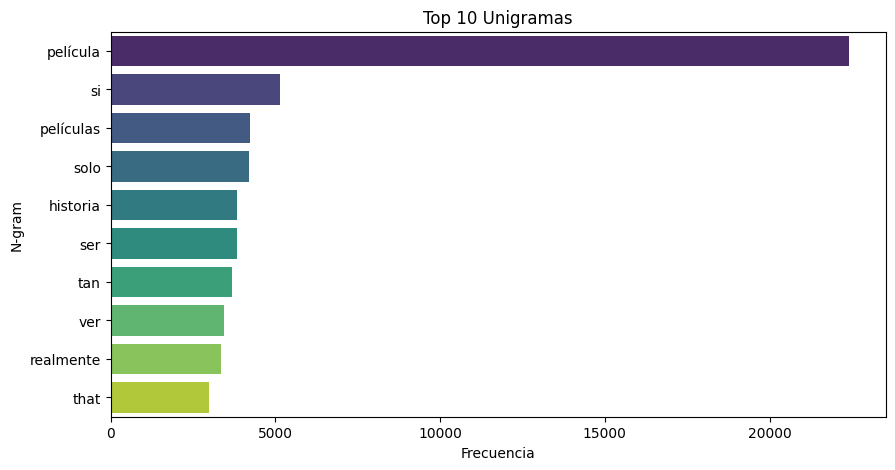

In [40]:
plot_ngrams(unigrams_df, 'Top 10 Unigramas')

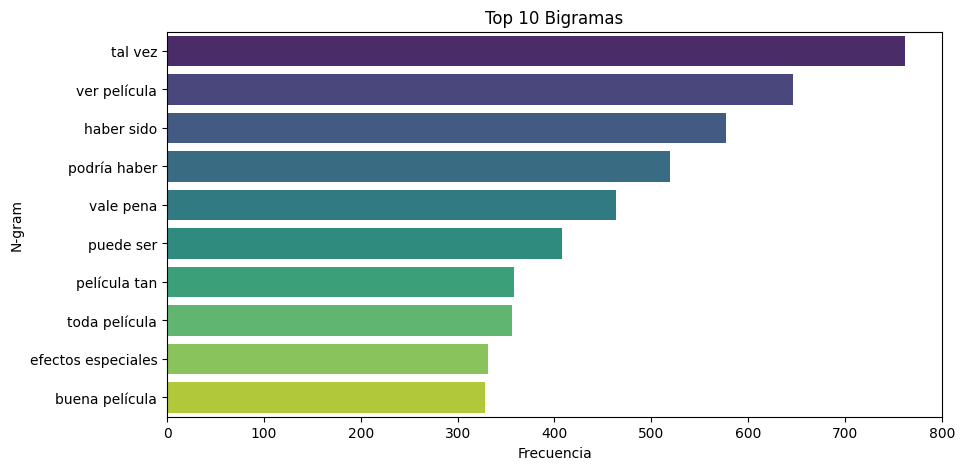

In [41]:
plot_ngrams(bigram_df, 'Top 10 Bigramas')

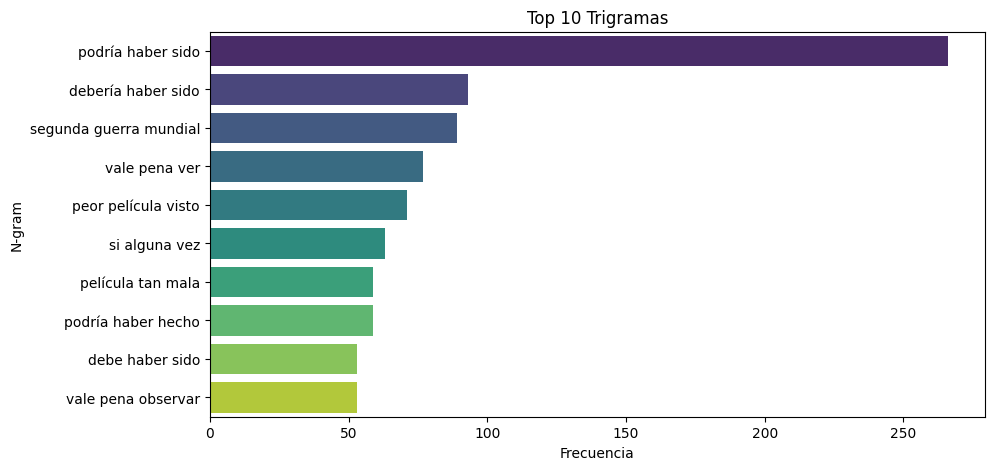

In [42]:
plot_ngrams(trigram_df, 'Top 10 Trigramas')

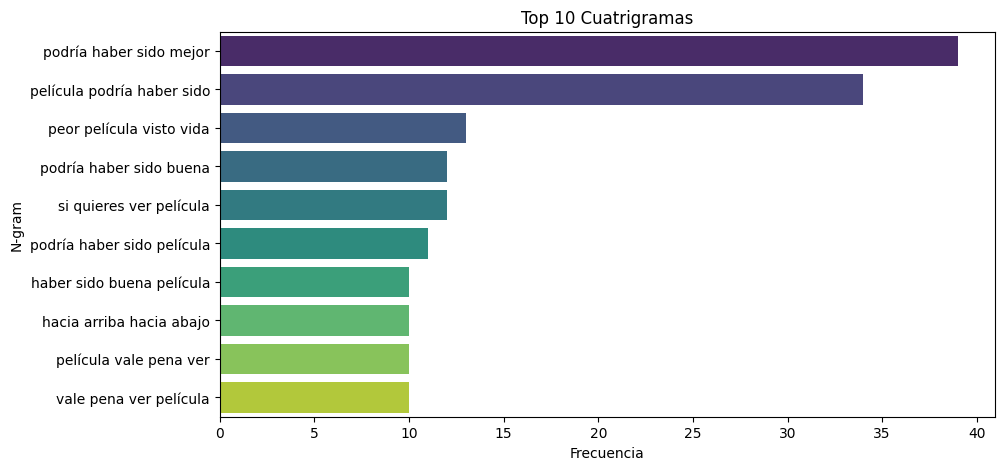

In [43]:
plot_ngrams(cuatrigram_df, 'Top 10 Cuatrigramas')

#Separar datos en entrenamiento y prueba

In [44]:
# Separar características (X) y etiquetas (y)
X = df['review_es_clean']  # Texto preprocesado
y = df['sentimiento']  # Etiquetas (1 = positivo, 0 = negativo)

In [45]:
# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [46]:
# Verificar tamaños de los conjuntos
print('Tamaño del conjunto de entrenamiento:', X_train.shape)
print('Tamaño del conjunto de prueba:', X_test.shape)

Tamaño del conjunto de entrenamiento: (6244,)
Tamaño del conjunto de prueba: (1561,)


In [47]:
# Verificar la distribución de clases en cada conjunto
print('Distribución de clases en entrenamiento:\n', y_train.value_counts(normalize=True))
print('Distribución de clases en prueba:\n', y_test.value_counts(normalize=True))

Distribución de clases en entrenamiento:
 sentimiento
0    0.50016
1    0.49984
Name: proportion, dtype: float64
Distribución de clases en prueba:
 sentimiento
0    0.50032
1    0.49968
Name: proportion, dtype: float64


La distribución de clases en los conjuntos de entrenamiento y prueba está balanceada, con aproximadamente un 50% de reseñas positivas y 50% negativas en ambos conjuntos. Esto significa que la división se realizó correctamente, evitando sesgos en el modelo.

In [48]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [49]:
# Entrenar el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [50]:
# Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

In [51]:
# Evaluación
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8270339525944908
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       781
           1       0.85      0.79      0.82       780

    accuracy                           0.83      1561
   macro avg       0.83      0.83      0.83      1561
weighted avg       0.83      0.83      0.83      1561



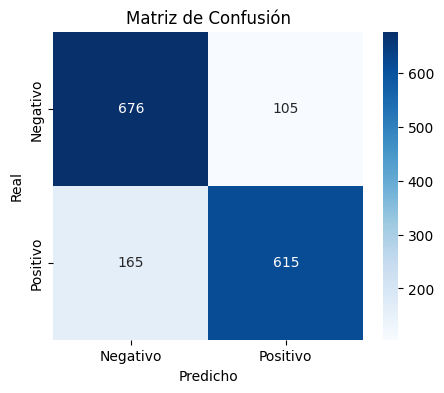

In [52]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

 Buen desempeño general con 82.7% de precisión.

In [53]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [54]:
from sklearn.linear_model import PassiveAggressiveClassifier # Corrected the typo in the class name
PassiveAggressiveClassifier # Now this should work without error

sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier

In [55]:
from sklearn.linear_model import PassiveAggressiveClassifier # Corrected the typo in the class name
pac = PassiveAggressiveClassifier(max_iter=50) # Corrected the typo in the class name
pac.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [56]:
y_pred2=pac.predict(tfidf_test)

In [57]:
# Evaluación
print('Accuracy:', accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.8597053171044202
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       781
           1       0.86      0.86      0.86       780

    accuracy                           0.86      1561
   macro avg       0.86      0.86      0.86      1561
weighted avg       0.86      0.86      0.86      1561



#Conclusiones generales

Comparando ambos modelos, el primero basado en **TF-IDF + Naïve Bayes** logró una precisión del **85.9%**, mostrando un buen equilibrio entre precisión y recall. Por otro lado, el modelo anterior presentó resultados similares, pero con ligeras diferencias en la detección de clases.  

En general, ambos modelos ofrecen un desempeño sólido en el análisis de sentimientos, con una correcta clasificación de opiniones positivas y negativas. Sin embargo, aún hay margen de mejora mediante la optimización de hiperparámetros, una mejor limpieza del texto y la exploración de modelos más avanzados, como redes neuronales o técnicas de ensamblado.